# User Defined Types

User Defined Types (UDT) allow you to define a custom Matrix element type.  For example in the shortest path problem, it can be useful to calculate not just the path length, but the number of hops along the shortest path, and a tree of shortest paths from every node back to the source.  This example is a high level translate of the `LAGraph_BF_full` function implementing the [Bellman-Ford algorithm](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm)

In [1]:
from pygraphblas import *
from pygraphblas.demo.gviz import draw

A new UDT requires a few peices, a type definition, identity value and addition and multiplication operators.  pygraphblas uses the [Numba](https://numba.pydata.org/) library to jit compile functions for GraphBLAS custom operators.  The first piece is the type definition.  This is a C structure that should contain only scalar values.

In [2]:
@udt
class BF:
    members = ['double w', 'uint64_t h', 'uint64_t pi']

The operators are regular python functions that are JIT compiled into operator functions.  Here are three functions, an equality function, and min function, and a plus for 

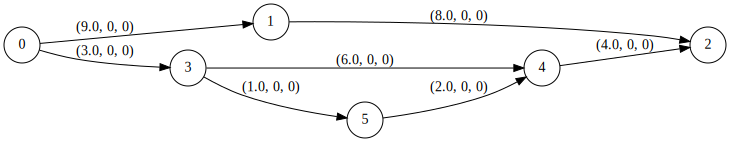

In [3]:
@BF.binop('eq_op', boolean=True) 
def bf_eq(z, x, y):
    if not x.w == y.w and x.h == y.h and x.pi == y.pi:
        z = True
    z = False

@BF.binop('add_op')
def bf_min(z, x, y):
    if (x.w < y.w 
        or x.w == y.w and x.h < y.h 
        or x.w == y.w and x.h == y.h and x.pi < y.pi):
        if (z.w != x.w and z.h != x.h and z.pi != x.pi):
            z.w = x.w
            z.h = x.h
            z.pi = x.pi        
    else:
        z.w = y.w
        z.h = y.h
        z.pi = y.pi   
    
@BF.binop('mult_op')
def bf_plus(z, x, y):
    z.w = x.w + y.w
    z.h = x.h + y.h
    if x.pi != lib.UINT64_MAX and y.pi != 0:
        z.pi = y.pi
    else:
        z.pi = x.pi

bf_identity = BF.from_value((lib.INFINITY, lib.UINT64_MAX, lib.UINT64_MAX))
bf_monoid = BF.new_monoid(bf_min, bf_identity)
bf_semiring = BF.new_semiring(bf_monoid, bf_plus)

A = Matrix.from_type(BF, 6, 6)
A[0,1] = (9.0, 0, 0)
A[0,3] = (3.0, 0, 0)
A[1,2] = (8.0, 0, 0)
A[3,4] = (6.0, 0, 0)
A[3,5] = (1.0, 0, 0)
A[4,2] = (4.0, 0, 0)
A[5,4] = (2.0, 0, 0)
draw(A)

The function below computes the shortest path, applying the custom semiring defined above to compute not just length but hop counts and path tree.

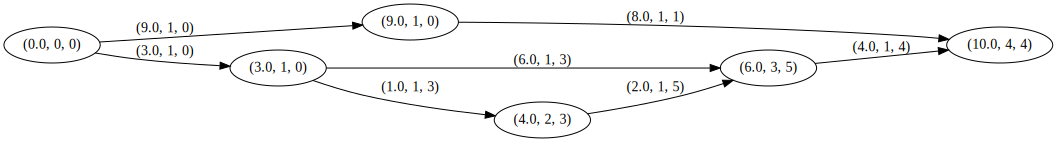

In [5]:
def bf_shortest_path(matrix, start):
    n = matrix.nrows
    v = Vector.from_type(matrix.type, n)
    for i, j, k in matrix:
        if i == j:
            matrix[i,j] = (0, 0, 0)
        else:
            matrix[i,j] = (k[0], 1, i)        
    v[start] = (0, 0, 0)
    with bf_semiring, Accum(bf_min):
        for _ in range(matrix.nrows):
            w = v.dup()
            v @= matrix
            if w.iseq(v):
                break
        return v

draw(A, label_vector=bf_shortest_path(A, 0))